## Loading and Inspecting the Dataset
First, let's load the dataset and take a preliminary look at its structure.

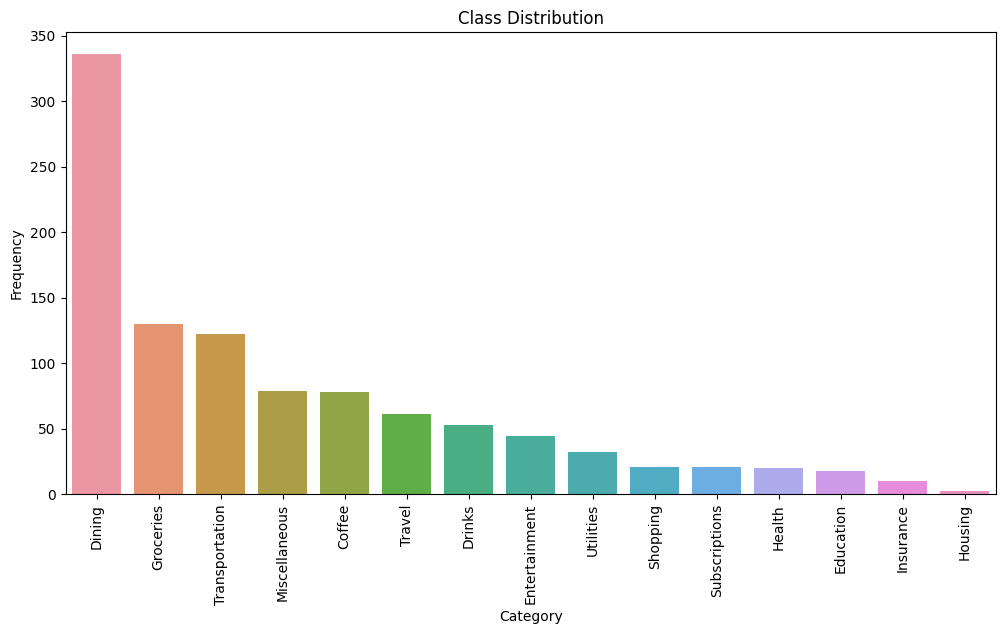

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/kaggle/input/no-negative-transactions/amex_all_categorized_raw.csv'  # Update this to your actual file path
data = pd.read_csv(file_path)

# Visualizing class distribution
plt.figure(figsize=(12, 6))
class_counts = data['Category'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.title('Class Distribution')
plt.show()



## Preprocessing and Splitting the Dataset
We'll preprocess the dataset by splitting into train and test set as well as use stratified sampling.

In [6]:
from sklearn.model_selection import train_test_split

# Split data into X and y
X = data['Description']
y = data['Category']

# Splitting the dataset (optional)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Setting Up the Pipeline and Grid Search CV for Hyperparameter Tuning
We'll use TF-IDF for text processing and feature extraction. Random Forest classifier with k-fold cross validation to categorize transactions based on their processed descriptions.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', RandomForestClassifier(random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'tfidf__max_features': [None, 5000, 10000]
}

# Setup GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'clf__max_depth': None, 'clf__n_estimators': 200, 'tfidf__max_features': None}
Best score: 0.744249815225425


## Evaluation on test set
Evaluate the model's performance using accuracy, precision, recall, f1 score, and the confusion matrix.

Test Classification Report:
                precision    recall  f1-score   support

        Coffee       0.75      0.75      0.75        16
        Dining       0.77      0.81      0.79        67
        Drinks       0.88      0.64      0.74        11
     Education       0.17      1.00      0.30         4
 Entertainment       0.33      0.11      0.17         9
     Groceries       0.96      0.96      0.96        26
        Health       1.00      0.50      0.67         4
     Insurance       0.67      1.00      0.80         2
 Miscellaneous       0.87      0.81      0.84        16
      Shopping       1.00      0.25      0.40         4
 Subscriptions       1.00      1.00      1.00         4
Transportation       0.77      0.68      0.72        25
        Travel       1.00      0.50      0.67        12
     Utilities       0.71      0.83      0.77         6

      accuracy                           0.74       206
     macro avg       0.78      0.70      0.68       206
  weighted avg    

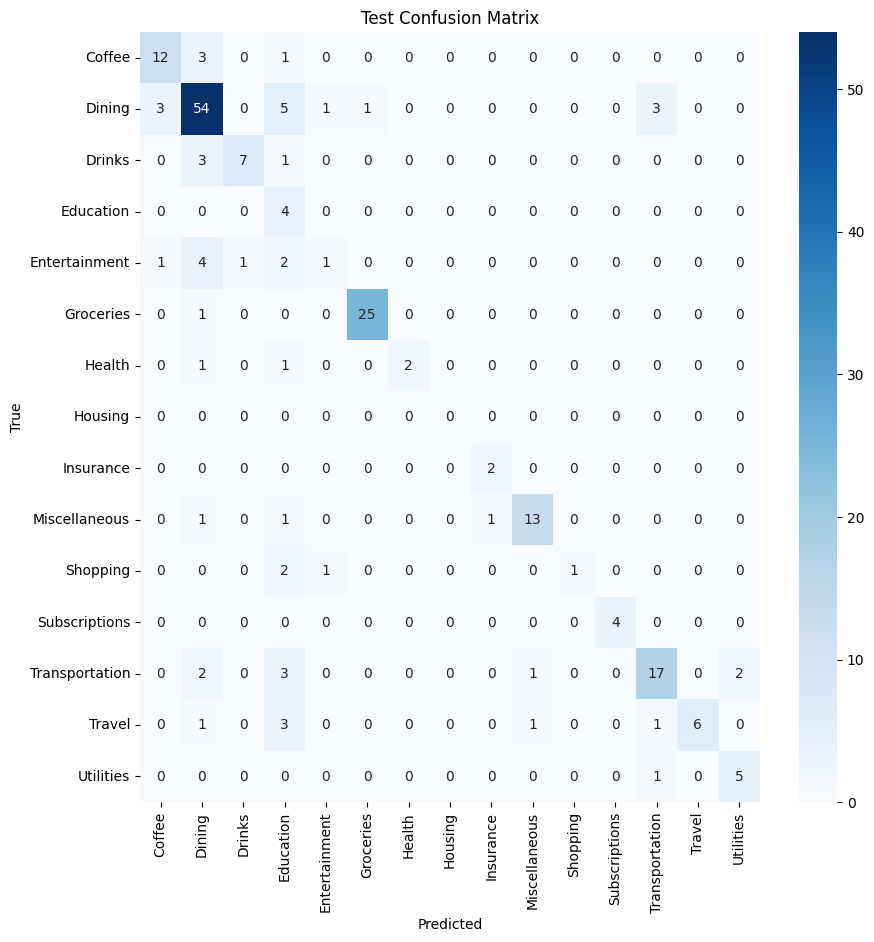

In [9]:
# Evaluate on the test set
y_test_pred = grid_search.predict(X_test)

# Detailed classification report
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Test Metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
print(f"Test Metrics\nPrecision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}, Accuracy: {test_accuracy:.4f}")

# Confusion Matrix for Test Set
test_cm = confusion_matrix(y_test, y_test_pred, labels=grid_search.classes_)
plt.figure(figsize=(10, 10))
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", xticklabels=grid_search.classes_, yticklabels=grid_search.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()


## Display Test Set With Predictions

In [10]:
# Create a DataFrame with actual and predicted categories for the test set
results_df = pd.DataFrame({'Description': X_test, 'Actual Category': y_test, 'Predicted Category': y_test_pred})

# Reset index to make it more readable
results_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
print(results_df.head(20))  # Show the first 20 results; adjust as needed

                   Description Actual Category Predicted Category
0      TST Chick-fil-A Phoenix          Dining             Dining
1    Princess Cruises Passport          Travel          Education
2                Target Durham        Shopping           Shopping
3               impact eats wf          Dining             Dining
4                 w addison st   Entertainment             Coffee
5          Jewel Osco Evanston       Groceries          Groceries
6            American Airlines          Travel             Travel
7                 Orca Seattle   Entertainment          Education
8                      Spotify   Subscriptions      Subscriptions
9           duke divinity cafe          Dining             Dining
10           Mariano's Chicago       Groceries          Groceries
11           Mariano's Chicago       Groceries          Groceries
12  tst annapurna simplchicago          Dining             Dining
13              Aplpay cafe at          Dining             Coffee
14        